# Теория информации

In [ ]:
#all imports here please
import pickle as pkl

from collections import OrderedDict, Counter
import heapq
import math

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#... add your own if necessary

Энтропию можно использовать не только для описания хаотичности, беспорядочности и уровня неопределённости, но и для того, чтобы исследовать зависимость между случайными величинами, используя теорию информации.

## Строим свой код, основанный на частотах

Представим себе для примера достаточно большую книгу (например, Войну и Мир Льва Николаевича Толстого). Для того, чтобы записывать буквы в кодировке UTF-8 требуется от 2 до 4 байт (каждый 8бит). Но книга -- это не просто какой-то iid равновероятный поток символов, а структурированный текст, структуру которого можно по-разному использовать. К примеру, мы можем задуматься над тем, чтобы сжать её, используя информацию о том, какие символы встречаются чаще: ведь более частые можно кодировать более короткими кодовыми словами, а более редкие -- более длинными.

В этом идея [кода Хаффмана](https://compression.ru/download/articles/huff/huffman_1952_minimum-redundancy-codes.pdf), который мы попробуем поисследовать в самой простой наивной имплементации.

### Вычисляем языковую статистику

Возьмём для примера текст вики-страницы [МО1](http://wiki.cs.hse.ru/%D0%9C%D0%B0%D1%88%D0%B8%D0%BD%D0%BD%D0%BE%D0%B5_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_1)

In [ ]:
with open("moText.txt","r", encoding="utf-8") as f:
    MOText = "\n".join(f.readlines())

print(MOText[:180])

== О курсе ==



[[Файл:ML_surfaces.png|280px|borderless|left]]



Курс читается для студентов 3-го курса [https://cs.hse.ru/ami ПМИ ФКН ВШЭ] в 1-2 модулях.



Проводится с 2016 го


Это не сильно большой, но не очень маленький текст.

In [ ]:
print(len(MOText))

10001


Вычислите частоту каждого символа, сохранив их в упорядоченный словарь (OrderedDict, пригодится для сортировок)  вида {<символ>: <частота>}.

In [ ]:
def compute_frequencies(text):
    freqs = dict()
    for char in text:
        if char not in freqs:
            freqs[char] = 1;
        else:
            freqs[char] += 1
    total = sum(freqs.values())
    return OrderedDict((char, count / total) for char, count in freqs.items())

In [ ]:
#compute OrderedDict
symFreqs = compute_frequencies(MOText)

In [ ]:
for key,val in symFreqs.items():
    print(f"{key}: {val}")
print(f"In total {len(symFreqs)} unique symbols, max freq= {max([val for val in symFreqs.values()])}")

=: 0.008899110088991101
 : 0.09119088091190881
О: 0.0012998700129987
к: 0.013398660133986601
у: 0.0098990100989901
р: 0.0184981501849815
с: 0.017998200179982
е: 0.038896110388961104

: 0.0524947505249475
[: 0.008099190080991902
Ф: 0.0005999400059994001
а: 0.0377962203779622
й: 0.006299370062993701
л: 0.015898410158984102
:: 0.009599040095990401
M: 0.0026997300269973002
L: 0.0012998700129987
_: 0.0051994800519948
s: 0.019698030196980302
u: 0.0058994100589941
r: 0.0124987501249875
f: 0.0023997600239976003
a: 0.014498550144985502
c: 0.0066993300669933005
e: 0.0216978302169783
.: 0.016298370162983702
p: 0.011398860113988602
n: 0.010498950104989501
g: 0.004399560043995601
|: 0.0184981501849815
2: 0.013998600139986002
8: 0.0008999100089991
0: 0.007699230076992301
x: 0.0012998700129987
b: 0.0029997000299970002
o: 0.013998600139986002
d: 0.0045995400459954
l: 0.0086991300869913
t: 0.030496950304969503
]: 0.008099190080991902
К: 0.0040995900409959
ч: 0.008899110088991101
и: 0.0342965703429657
т

### Строим Кодер и Декодер Хаффмана

In [ ]:
#taken from https://www.geeksforgeeks.org/huffman-coding-in-python/
class Node:
    def __init__(self, symbol=None, frequency=None):
        #print("CREATING", symbol, frequency)
        self.symbol = symbol
        self.frequency = frequency
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.frequency < other.frequency

def build_huffman_tree(chars, freq):

    # Create a priority queue of nodes
    priority_queue = [Node(char, f) for char, f in zip(chars, freq)]
    heapq.heapify(priority_queue)

    # Build the Huffman tree
    while len(priority_queue) > 1:
        left_child = heapq.heappop(priority_queue)
        right_child = heapq.heappop(priority_queue)
        merged_node = Node(frequency=left_child.frequency + right_child.frequency)
        merged_node.left = left_child
        merged_node.right = right_child
        heapq.heappush(priority_queue, merged_node)

    return priority_queue[0]

def generate_huffman_codes(node, code="", huffman_codes={}):
    if node is not None:
        if node.symbol is not None:
            huffman_codes[node.symbol] = code
        else:
            generate_huffman_codes(node.left, code + "0", huffman_codes)
            generate_huffman_codes(node.right, code + "1", huffman_codes)

    return huffman_codes

def runTest():
    # Given example (try it to test)
    chars = ['a', 'b', 'c', 'd', 'e', 'f']
    freq = [4, 7, 15, 17, 22, 42]

    # Build the Huffman tree
    root = build_huffman_tree(chars, freq)

    # Generate Huffman codes
    huffman_codes = generate_huffman_codes(root)

    # Print Huffman codes
    for char, code in huffman_codes.items():
        print(f"Character: {char}, Code: {code}")

runTest()

Character: f, Code: 0
Character: a, Code: 1000
Character: b, Code: 1001
Character: c, Code: 101
Character: d, Code: 110
Character: e, Code: 111


In [ ]:
class HuffmanCoderDecoder:

    def __init__(self,symbolProbaTable):
        """_summary_

        Args:
            symbolProbaTable (dict): a dict with symbol(keys) and probabilities (val)
        """
        self.symbols = list(symbolProbaTable.keys())
        self.probas = list(symbolProbaTable.values())
        self.symbolProbaTable = symbolProbaTable
        self.root = None
        self.fit()

    def fit(self):
        """
        Sets up encoder and decoder tables
        """
        self.root = build_huffman_tree(self.symbols, self.probas)
        self.encoderTable = generate_huffman_codes(self.root, code="", huffman_codes={})
        self.decoderTable = {code: symbol for symbol, code in self.encoderTable.items()}

    def encode(self, text):
        """Encodes the text and returns encoded text

        Args:
            text (str): text to encode
        Returns:
            encodedText (str): encoded text
        """
        encodedText = ''.join(self.encoderTable[char] for char in text if char in self.encoderTable)
        return encodedText

    def decode(self, text):
        """Decodes the encoded text and returns decoded text

        Args:
            text (str): text to decode
        Returns:
            decodedText (str): decoded text
        """
        decodedText = ""
        current = ""
        for bit in text:
            current += bit
            if current in self.decoderTable:
                decodedText += self.decoderTable[current]
                current = ""

        return decodedText

In [ ]:
textSample = MOText[:200]

#Create coder
huff = HuffmanCoderDecoder(symFreqs)
#Encode text
encText = huff.encode(textSample)
#decode text to check if it works
decText = huff.decode(encText)

In [ ]:
print(encText)

1011100101110000011101110100000011111101111110011101111111000001011100101110001000100010001001001100100110011011010000110100011000100011110111011101111111111010001110110111101000100000010101101101010111010101010111101111010100101111111011110001011011011001001101001101111010111111111111011101100111100100010011001011100101011011000111101001010101101011110111101011101011001010110101111011101101011000010010011001001010001000100010010011010110111111001110111100010111011010010110011010111001011001011110101101000011100100011010110100010111110110011011110111001110010101101100110001000100000011011100110110111110011100000000111111011111100111011111101000010011000111101000010000111111011101011011100110001100010101011101010010101111011101011110110010100101000100000110001110100101101010000011111011111110000111110100011011010000100110100010010000001110111001011011110110110111111001001000100010000001100101101100110100001111001110000111001101111100011010110101101110010010101000100010001001111101111001

In [ ]:
print(decText)

== О курсе ==



[[Файл:ML_surfaces.png|280px|borderless|left]]



Курс читается для студентов 3-го курса [https://cs.hse.ru/ami ПМИ ФКН ВШЭ] в 1-2 модулях.



Проводится с 2016 года.



'''Лектор:'''


In [ ]:
print(textSample)

== О курсе ==



[[Файл:ML_surfaces.png|280px|borderless|left]]



Курс читается для студентов 3-го курса [https://cs.hse.ru/ami ПМИ ФКН ВШЭ] в 1-2 модулях.



Проводится с 2016 года.



'''Лектор:'''


Вычислите, какое получилось сжатие

In [ ]:
print("Compression(%): ",len(textSample.encode('utf-8'))*8/len(encText)*100)

Compression(%):  180.43654001616815


Поздравляем, вы сделали простой алгоритм сжатия) .... если у вас больше 100%

### Исследуем, как хорошо себя ведёт код при смене текста

Сравните написанный кодер на двух понравившихся вам текстах на разные темы (возьмите по масштабу что-то похожее на страницу МО).

1. Для чистоты эксперимента очистите оба текста от символов, которых нет в другом тексте
2. Посчитайте таблицу частот для каждого из текстов
3. Обучите кодер на тексте 1
4. Обучите кодер на тексте 2
5. Сопоставьте длину (в битах):
   1. Текст1, закодированный кодером 1
   2. Текст2, закодированный кодером 1
   3. Текст1, закодированный кодером 2
   4. Текст2, закодированный кодером 2
6. Посчитайте KL-дивергенцию и кроссэнтропию в обе стороны между частотами кодера1 и кодера2

Прокомментируйте результат.

Не забудьте приложить к решению ваших два текстовых файла.

In [ ]:
with open("text1.txt","r", encoding="utf-8") as f:
    text1 = "\n".join(f.readlines())
with open("text2.txt","r", encoding="utf-8") as f:
    text2 = "\n".join(f.readlines())

In [ ]:
common_chars = set(text1) & set(text2)
text1 = ''.join([c for c in text1 if c in common_chars])
text2 = ''.join([c for c in text2 if c in common_chars])

In [ ]:
freq1 = compute_frequencies(text1)
freq2 = compute_frequencies(text2)

In [ ]:
coder1 = HuffmanCoderDecoder(freq1)
coder2 = HuffmanCoderDecoder(freq2)

In [ ]:
text1_coder1 = len(coder1.encode(text1))
text2_coder1 = len(coder1.encode(text2))
text1_coder2 = len(coder2.encode(text1))
text2_coder2 = len(coder2.encode(text2))

In [ ]:
def cross_entropy(freq_w, freq_p):
    return -sum(freq_w[c] * math.log2(freq_p[c]) for c in freq_w.keys())

def kl_divergence(freq_w, freq_p):
    return -sum(freq_w[c] * math.log2(freq_p[c] / freq_w[c]) for c in freq_w.keys())

In [ ]:
kl_text1_text2 = kl_divergence(freq1, freq2)
kl_text2_text1 = kl_divergence(freq2, freq1)
ce_text1_text2 = cross_entropy(freq1, freq1)
ce_text2_text1 = cross_entropy(freq2, freq2)
H_text1 = ce_text1_text2 - kl_text1_text2
H_text2 = ce_text2_text1 - kl_text2_text1

In [ ]:
print( f"KL(text1 | text2)={kl_text1_text2}" )
print( f"KL(text2 | text1)={kl_text2_text1}" )
print( f"CE(text1 | text2)={ce_text1_text2}" )
print( f"CE(text2 | text1)={ce_text2_text1}" )
print( f"H(text1)={H_text1}" )
print( f"H(text2)={H_text2}" )

KL(text1 | text2)=0.056794669312650974
KL(text2 | text1)=0.05047753326994205
CE(text1 | text2)=4.618814388429162
CE(text2 | text1)=4.534943593022008
H(text1)=4.5620197191165115
H(text2)=4.484466059752066


In [ ]:
print(f"Coding with text1: text1Len={text1_coder1}, text2Len={text2_coder1}")
print(f"Coding with text2: text1Len={text1_coder2}, text2Len={text2_coder2}")

Coding with text1: text1Len=60723, text2Len=64258
Coding with text2: text1Len=61273, text2Len=63550


Длина увеличивается, если кодировать текст кодером, основанном на другом тексте, но незначительно.

In [ ]:
#ADD A CHART like https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
#and draw distributions of text1 and text2
#f, ax = plt.subplots
#....

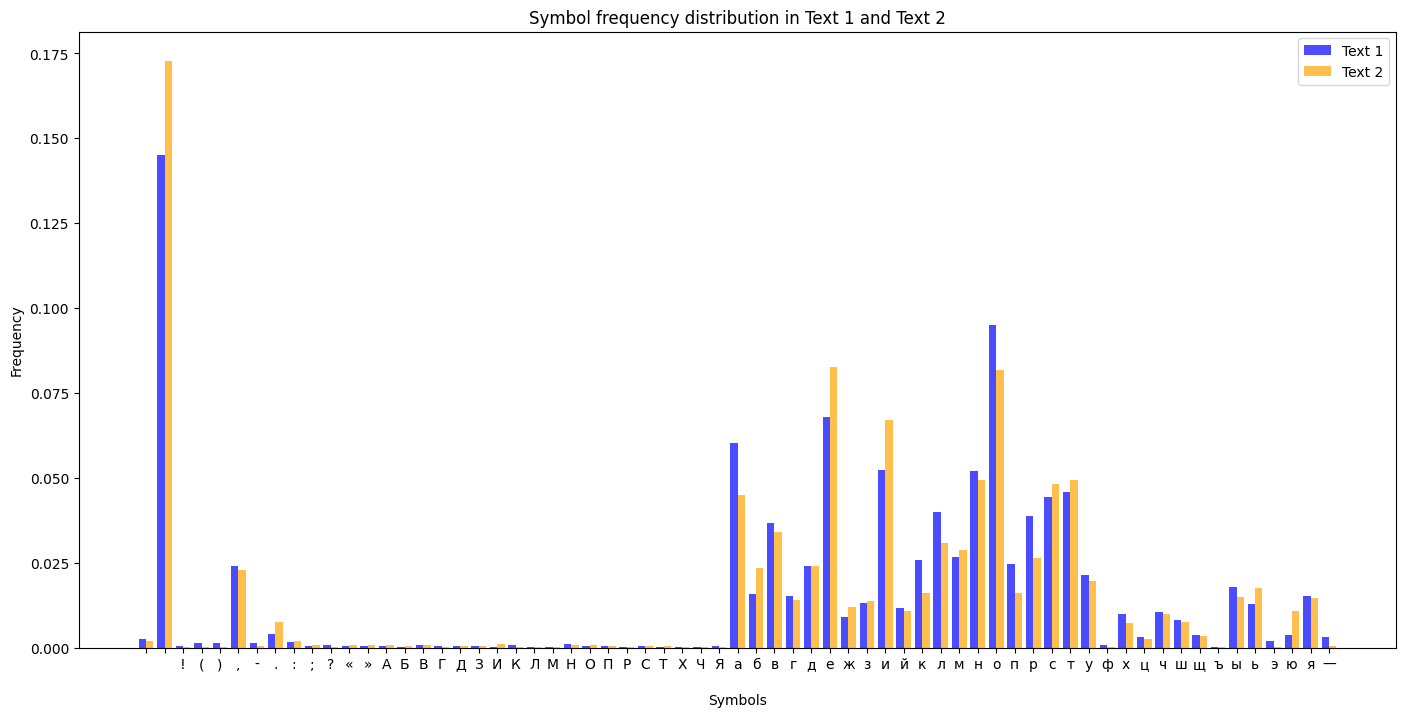

In [ ]:
symbols = sorted(freq1.keys())
values1 = [freq1.get(symbol, 0) for symbol in symbols]
values2 = [freq2.get(symbol, 0) for symbol in symbols]
fig, ax = plt.subplots(figsize=(17, 8))

index = np.arange(len(symbols))
bar_width = 0.4

bars1 = ax.bar(index, values1, bar_width, label='Text 1', color='blue', alpha=0.7)
bars2 = ax.bar(index + bar_width, values2, bar_width, label='Text 2', color='orange', alpha=0.7)

ax.set_xlabel('Symbols')
ax.set_ylabel('Frequency')
ax.set_title('Symbol frequency distribution in Text 1 and Text 2')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(symbols)
ax.legend()
plt.show()

Значения энтропии (то есть средняя длина слова при оптимальном кодировании) для двух текстов практически совпадает, обе KL-дивергенции малы и равны примерно 0.05, также распределние частот для символов отличается лишь незначительно. Данные два текста очень похожи, несмотря на то, что написаны на разные темы, разными людьми, что логично, ведь мы всё-таки использовали достаточно объемные тексты на одном языке (которые не были написаны каким-то специальным образом, например, чтобы в тексте очень часто встречалась буква а). Всё это говорит о том, что мы можем создать один кодер (на основе одного из текстов) и использовать его для кодирования других текстов, так мы не сильно увеличим среднюю длину слова.